In [ ]:
import numpy as np
import queue
from statistics import mean
import matplotlib.pyplot as plt
import math
import random

In [ ]:
def avl_server(t,servers):
    low = len(servers)
    i = 0
    for s in servers:
        if t > s[1]:
            if low == len(servers):
                low = i
            elif s[1] < servers[low][1]:
                low = i
        i += 1
    if low < len(servers):
        return low #return server with earliest idle time
    return len(servers)

def get_avl_servers(t,servers,n):
    empty = []
    i = 0
    for s in servers:
        if t >= s[1]: #get empty servers
            empty.append((i,s[1]))
        i += 1
    empty.sort(key = lambda x: x[1])
    return empty[:n] #return the [server index,free time]

def busy_server_n(t,servers):
    n = 0
    i = 0
    for s in servers:
        if t >= s[1] or t < s[0]: #get empty servers
            n += 1
            #print(i)
        i+=1
    return len(servers)-n #reverse


In [ ]:
arr_rate = 10
duration = 3600*5
job_size = 5

server_n = 6
srv_rate = 7.5

t = 0
jobs_arr_t = []
while t <= duration:
    iat = np.random.exponential(1/arr_rate)
    t += iat
    #jobs_arr_t.append((t,random.choice([1,job_size])))
    jobs_arr_t.append((t,random.randint(1,job_size)))

jobs_arr_t

In [ ]:
comb_wt = []
comb_rt = []
comb_sl = []
comb_qs = []

waiting_times = []
response_times = []
queue = []

servers = [] #[service_start,end]
for s in range(server_n):
    servers.append([0,0])

busy_times = []
for s in range(server_n):
    busy_times.append([])

server_load = [[0,0]]
queue_size = [[0,0]]

job_id = 0
while job_id < len(jobs_arr_t):
    t = 999999999
    curr_job = jobs_arr_t[job_id]        
    for s in servers:
        if s[1] > 0 and s[1] < t and s[1] > server_load[-1][0]:
            t = s[1]
    if jobs_arr_t[job_id][0] < t:
        t = jobs_arr_t[job_id][0]
        queue.append(curr_job)
        job_id += 1
    print(t)
    
    if len(queue) > 0:
        job = queue[0] #only at the front
        avl_servers_n = len(servers)-busy_server_n(t,servers)
        if avl_servers_n >= job[1]:
            ready_servers = get_avl_servers(t,servers,job[1])
            st = np.random.exponential(1/srv_rate)
            for s in ready_servers:
                server_id = s[0]
                servers[server_id] = [t,t+st]
            waiting_times.append((t-job[0],job[1]))
            response_times.append((t+st-job[0],job[1]))
            queue.pop(0)
    
    server_load.append((t,busy_server_n(t,servers)))
    queue_size.append((t,len(queue)))

comb_wt.append(waiting_times)
comb_rt.append(response_times)
comb_sl.append(server_load)
comb_qs.append(queue_size)


# NON FIFO (CAN TAKEOVER)
waiting_times = []
response_times = []
queue = []

servers = [] #[service_start,end]
for s in range(server_n):
    servers.append([0,0])

busy_times = []
for s in range(server_n):
    busy_times.append([])

server_load = [[0,0]]
queue_size = [[0,0]]

job_id = 0
while job_id < len(jobs_arr_t):
    t = 999999999
    curr_job = jobs_arr_t[job_id]        
    for s in servers:
        if s[1] > 0 and s[1] < t and s[1] > server_load[-1][0]:
            t = s[1]
    if jobs_arr_t[job_id][0] < t:
        t = jobs_arr_t[job_id][0]
        queue.append(curr_job)
        job_id += 1
    print(t)
    
    queue_id = 0
    while queue_id < len(queue):
        avl_servers_n = len(servers)-busy_server_n(t,servers)
        if avl_servers_n == 0:
            break
        job = queue[queue_id]
        if avl_servers_n >= job[1]:
            ready_servers = get_avl_servers(t,servers,job[1])
            st = np.random.exponential(1/srv_rate)
            for s in ready_servers:
                server_id = s[0]
                servers[server_id] = [t,t+st]
            waiting_times.append((t-job[0],job[1]))
            response_times.append((t+st-job[0],job[1]))
            queue.pop(queue_id)
            queue_id = 0
        else:
            queue_id += 1
    server_load.append((t,busy_server_n(t,servers)))
    queue_size.append((t,len(queue)))

comb_wt.append(waiting_times)
comb_rt.append(response_times)
comb_sl.append(server_load)
comb_qs.append(queue_size)

In [151]:
servers

[[17999.87810756426, 18000.18837747645],
 [18000.017395725772, 18000.35565290246],
 [18000.017395725772, 18000.35565290246],
 [18000.017395725772, 18000.35565290246],
 [18000.017395725772, 18000.35565290246],
 [17999.87810756426, 18000.18837747645]]

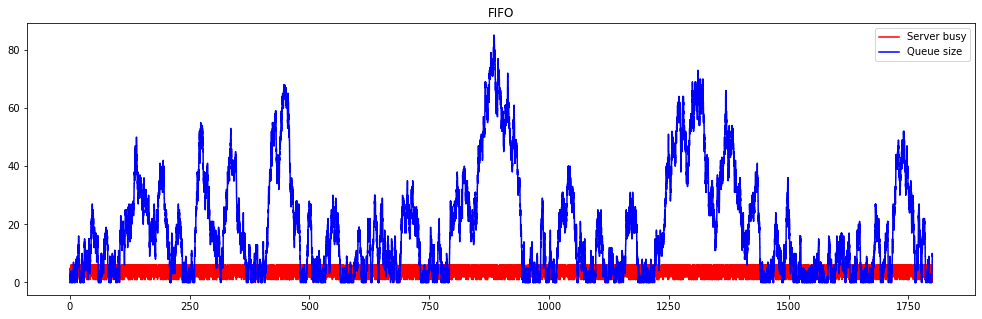

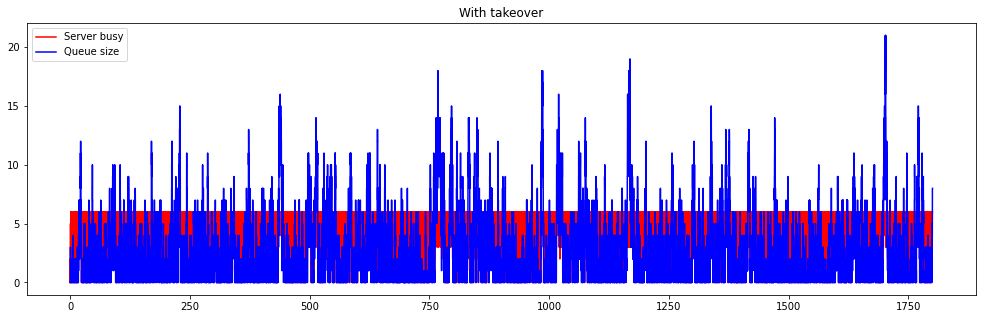

In [156]:
start_t = 0
end_t = 1800

server_load = comb_sl[0]
queue_size = comb_qs[0]
tmp_server = []
tmp_queue = []
init_sl = -1
for j in server_load:
    if j[0] < start_t:
        init_sl += 1
        continue
    if j[0] > end_t:
        break
    tmp_server.append(j)
if init_sl >= 0:
    tmp_server = [[start_t,server_load[init_sl][1]]] + tmp_server
tmp_server.append([end_t,tmp_server[-1][1]])

init_qs = -1
for q in queue_size:
    if q[0] < start_t:
        init_qs += 1
        continue
    if q[0] > end_t:
        break
    tmp_queue.append(q)
if init_qs >= 0:
    tmp_queue = [[start_t,queue_size[init_qs][1]]] + tmp_queue
tmp_queue.append([end_t,tmp_queue[-1][1]])

plt.figure(figsize=(17,5))
plt.step([q[0] for q in tmp_server], [q[1] for q in tmp_server], 'r', where='post', label = 'Server busy')
plt.step([q[0] for q in tmp_queue], [q[1] for q in tmp_queue], 'b', where='post', label = 'Queue size')
plt.legend()
plt.title('FIFO')
plt.show()

server_load = comb_sl[1]
queue_size = comb_qs[1]
tmp_server = []
tmp_queue = []
init_sl = -1
for j in server_load:
    if j[0] < start_t:
        init_sl += 1
        continue
    if j[0] > end_t:
        break
    tmp_server.append(j)
if init_sl >= 0:
    tmp_server = [[start_t,server_load[init_sl][1]]] + tmp_server
tmp_server.append([end_t,tmp_server[-1][1]])

init_qs = -1
for q in queue_size:
    if q[0] < start_t:
        init_qs += 1
        continue
    if q[0] > end_t:
        break
    tmp_queue.append(q)
if init_qs >= 0:
    tmp_queue = [[start_t,queue_size[init_qs][1]]] + tmp_queue
tmp_queue.append([end_t,tmp_queue[-1][1]])

plt.figure(figsize=(17,5))
plt.step([q[0] for q in tmp_server], [q[1] for q in tmp_server], 'r', where='post', label = 'Server busy')
plt.step([q[0] for q in tmp_queue], [q[1] for q in tmp_queue], 'b', where='post', label = 'Queue size')
plt.legend()
plt.title('With takeover')
plt.show()

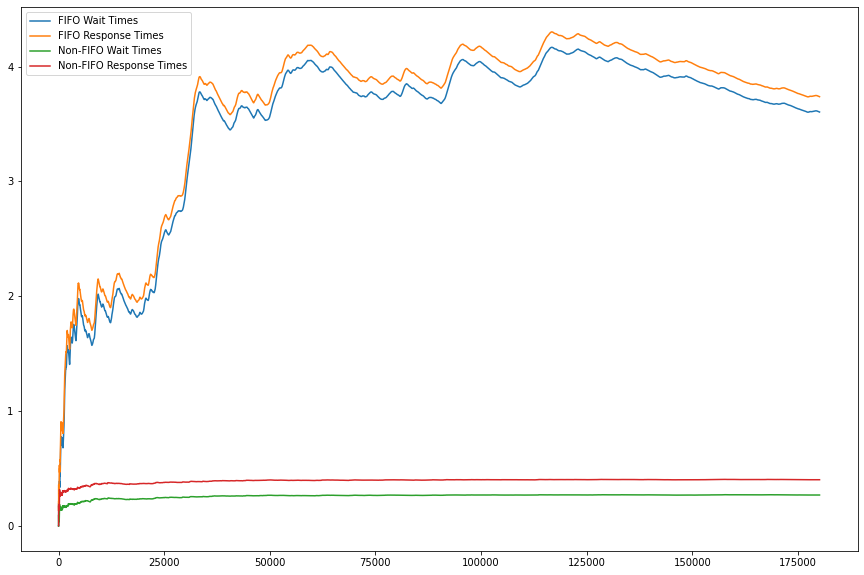

In [157]:
waiting_times = comb_wt[0]
response_times = comb_rt[0]
avg_wait = []
n = 1
tot = 0
for w in [wt[0] for wt in waiting_times]:
    tot += w
    avg_wait.append(tot/n)
    n += 1

avg_resp = []
n = 1
tot = 0
for w in [rt[0] for rt in response_times]:
    tot += w
    avg_resp.append(tot/n)
    n += 1

plt.figure(figsize=(15,10))
plt.plot([i for i in range(len(avg_wait))], avg_wait, label = "FIFO Wait Times")
plt.plot([i for i in range(len(avg_resp))], avg_resp, label = "FIFO Response Times")

waiting_times = comb_wt[1]
response_times = comb_rt[1]
avg_wait = []
n = 1
tot = 0
for w in [wt[0] for wt in waiting_times]:
    tot += w
    avg_wait.append(tot/n)
    n += 1

avg_resp = []
n = 1
tot = 0
for w in [rt[0] for rt in response_times]:
    tot += w
    avg_resp.append(tot/n)
    n += 1

plt.plot([i for i in range(len(avg_wait))], avg_wait, label = "Non-FIFO Wait Times")
plt.plot([i for i in range(len(avg_resp))], avg_resp, label = "Non-FIFO Response Times")
plt.legend()
plt.show()

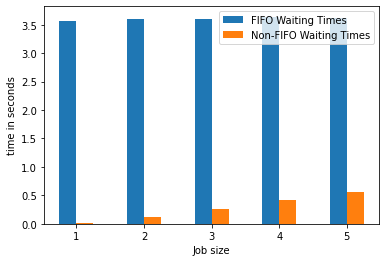

In [158]:
waiting_times = comb_wt[0]
response_times = comb_rt[0]
boxed_wait = []
for i in range(job_size):
    job_size = i+1
    tmp_wait = []
    for wt in waiting_times:
        if wt[1] == job_size:
            tmp_wait.append(wt[0])
    if len(tmp_wait) == 0:
        boxed_wait.append(0)
        continue
    boxed_wait.append(mean(tmp_wait))

boxed_resp = []
for i in range(job_size):
    job_size = i+1
    tmp_resp = []
    for rt in response_times:
        if rt[1] == job_size:
            tmp_resp.append(rt[0])
    if len(tmp_resp) == 0:
        boxed_resp.append(0)
        continue
    boxed_resp.append(mean(tmp_resp))

plt.bar([n for n in range(job_size)], boxed_wait, width = width, label = 'FIFO Waiting Times')
#plt.bar([n+1 for n in range(server_n)], boxed_resp, label = 'Avg Response Times')

waiting_times = comb_wt[1]
response_times = comb_rt[1]
boxed_wait = []
for i in range(job_size):
    job_size = i+1
    tmp_wait = []
    for wt in waiting_times:
        if wt[1] == job_size:
            tmp_wait.append(wt[0])
    if len(tmp_wait) == 0:
        boxed_wait.append(0)
        continue
    boxed_wait.append(mean(tmp_wait))

boxed_resp = []
for i in range(job_size):
    job_size = i+1
    tmp_resp = []
    for rt in response_times:
        if rt[1] == job_size:
            tmp_resp.append(rt[0])
    if len(tmp_resp) == 0:
        boxed_resp.append(0)
        continue
    boxed_resp.append(mean(tmp_resp))

width = 0.25
plt.bar([n+width for n in range(job_size)], boxed_wait, width = width, label = 'Non-FIFO Waiting Times')
plt.legend()
plt.xlabel('Job size')
plt.ylabel('time in seconds')
plt.xticks([n+(width/2) for n in range(job_size)],
        [n+1 for n in range(job_size)])
plt.show()

In [159]:
waiting_times = comb_wt[0]
response_times = comb_rt[0]
print(mean([wt[0] for wt in waiting_times]))
print(mean([rt[0] for rt in response_times]))
print('----------')

waiting_times = comb_wt[1]
response_times = comb_rt[1]
print(mean([wt[0] for wt in waiting_times]))
print(mean([rt[0] for rt in response_times]))

3.604083162105655
3.737645449056349
----------
0.27048835333374477
0.4035384758373565
